### Imports

In [47]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import warnings
import random
import IPython
import music21

from IPython.display import Image, Audio
from music21 import *
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.utils import to_categorical

In [2]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Data Aquisition and Exploration

## Data Loading

In [5]:
# filepath = 'music_dataset' # All tracks
filepath = 'music_dataset/mozart' # Mozart tracks

In [6]:
# Fetch MIDI files in filepath
midi_files = []

for root, directories, files in os.walk(filepath):
    for file in files:
        if file.endswith('.mid'):
            track = os.path.join(root, file) # Combine the root filepath and the filename to get full path
            midi_track = converter.parse(track)
            midi_files.append(midi_track)
            print(f'{track} added!')

print(f'{len(midi_files)} tracks imported!')

music_dataset/mozart\mz_311_1.mid added!
music_dataset/mozart\mz_311_2.mid added!
music_dataset/mozart\mz_311_3.mid added!
music_dataset/mozart\mz_330_1.mid added!
music_dataset/mozart\mz_330_2.mid added!
music_dataset/mozart\mz_330_3.mid added!
music_dataset/mozart\mz_331_1.mid added!
music_dataset/mozart\mz_331_2.mid added!
music_dataset/mozart\mz_331_3.mid added!
music_dataset/mozart\mz_332_1.mid added!
music_dataset/mozart\mz_332_2.mid added!
music_dataset/mozart\mz_332_3.mid added!
music_dataset/mozart\mz_333_1.mid added!
music_dataset/mozart\mz_333_2.mid added!
music_dataset/mozart\mz_333_3.mid added!
music_dataset/mozart\mz_545_1.mid added!
music_dataset/mozart\mz_545_2.mid added!
music_dataset/mozart\mz_545_3.mid added!
music_dataset/mozart\mz_570_1.mid added!
music_dataset/mozart\mz_570_2.mid added!
music_dataset/mozart\mz_570_3.mid added!
21 tracks imported!


In [7]:
def list_instruments(midi_stream):
    parts = instrument.partitionByInstrument(midi_stream)
    instrument_names = []
    
    if parts:  # If instruments are present
        for part in parts.parts:
            instr = part.getInstrument()  # Extract instrument details
            instrument_names.append(instr.instrumentName)
    else:  # Single instrument or no explicit partitioning
        instr = midi_stream.getInstrument()
        instrument_names.append(instr.instrumentName if instr.instrumentName else "Unknown Instrument")
    
    return len(instrument_names), instrument_names

In [9]:
for idx, midi_stream in enumerate(midi_files):
    num_instruments, instrument_names = list_instruments(midi_stream)
    print(f"MIDI file {idx + 1}: Number of instruments = {num_instruments}")
    print(f"Instrument names: {', '.join(instrument_names)}")

MIDI file 1: Number of instruments = 3
Instrument names: Piano right, Piano, Piano left
MIDI file 2: Number of instruments = 3
Instrument names: Piano right, Piano, Piano left
MIDI file 3: Number of instruments = 3
Instrument names: Piano right, Piano, Piano left
MIDI file 4: Number of instruments = 3
Instrument names: Piano right, Piano, Piano left
MIDI file 5: Number of instruments = 3
Instrument names: Piano right, Piano, Piano left
MIDI file 6: Number of instruments = 3
Instrument names: Piano right, Piano, Piano left
MIDI file 7: Number of instruments = 3
Instrument names: Piano right, Piano, Piano left
MIDI file 8: Number of instruments = 3
Instrument names: Piano right, Piano, Piano left
MIDI file 9: Number of instruments = 3
Instrument names: Piano right, Piano, Piano left
MIDI file 10: Number of instruments = 3
Instrument names: Piano right, Piano, Piano left
MIDI file 11: Number of instruments = 3
Instrument names: Piano right, Piano, Piano left
MIDI file 12: Number of instru

## Extracting musical features

In [14]:
def extract_music_features(midi_stream):
    notes = []
    durations = []
    tempos = []

    # Extract tempo from the stream
    tempo_marks = midi_stream.flat.getElementsByClass(tempo.MetronomeMark)
    tempo_value = tempo_marks[0].number if len(tempo_marks) > 0 else 120  # Default tempo = 120

    for element in midi_stream.flat.notesAndRests:
        if isinstance(element, (note.Note, chord.Chord)):
            # Extract pitches
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append(".".join(str(n.pitch) for n in element.notes))
            
            # Extract durations
            durations.append(element.quarterLength)

            # Tempo
            tempos.append(tempo_value)

        elif isinstance(element, note.Rest):
            # Add a rest placeholder
            notes.append("rest")
            durations.append(element.quarterLength)
            tempos.append(tempo_value)

    return notes, durations, tempos

In [17]:
example_stream = midi_files[0]
notes, durations, tempos = extract_music_features(example_stream)

print("Extracted Notes:", notes)
print("Extracted Durations:", durations)
print("Extracted Tempos:", tempos)

Extracted Notes: ['A4.D5.F#4', 'A2.D2.D3', 'rest', 'rest', 'G5', 'F#4.D4', 'F#5', 'E5', 'F#5', 'A5', 'E4.G4', 'G5', 'F#5', 'G5', 'A5', 'A4.F#4', 'rest', 'rest', 'A5', 'rest', 'rest', 'B5', 'rest', 'C#6', 'rest', 'rest', 'D6', 'rest', 'rest', 'A5', 'F#3', 'D4', 'F#5', 'D3', 'D4', 'A5', 'E3', 'G5', 'F#5', 'D4', 'G5', 'A5', 'A3', 'rest', 'rest', 'G5', 'C#4', 'rest', 'rest', 'F5', 'D3.D4', 'F#5', 'rest', 'rest', 'G5', 'D4.F#4', 'F#5', 'E5', 'F#5', 'A5', 'E4.G4', 'G5', 'F#5', 'G5', 'A5', 'F#4.A4', 'rest', 'rest', 'A5', 'rest', 'rest', 'B5', 'rest', 'C#6', 'rest', 'rest', 'D6', 'rest', 'rest', 'A5', 'F#3', 'D4', 'F#5', 'D3', 'D4', 'A5', 'E3', 'G5', 'F#5', 'D4', 'G5', 'A5', 'A3', 'G5', 'F#5', 'C#4', 'E5', 'D5', 'rest', 'D4', 'rest', 'rest', 'F#4', 'rest', 'A4', 'D4', 'rest', 'rest', 'F#4', 'rest', 'F#5.G5', 'D4', 'rest', 'F#5.G5', 'rest', 'F#4', 'F#5.G5', 'rest', 'F#5.G5', 'D4', 'rest', 'F#5', 'rest', 'E5', 'F#4', 'rest', 'D5', 'rest', 'rest', 'C#5', 'E4', 'rest', 'rest', 'G4', 'rest', 'A4', 

In [36]:
all_notes = []
all_durations = []
all_tempos = []

In [37]:
for midi_stream in midi_files:
    notes, durations, tempos = extract_music_features(midi_stream)
    all_notes.extend(notes)
    all_durations.extend(durations)
    all_tempos.extend(tempos)

--- Notes ---
Total unique notes: 1356
Average recurrence: 55.44
Most frequent notes appeared: 19371 times
Least frequent notes appeared: 1 time


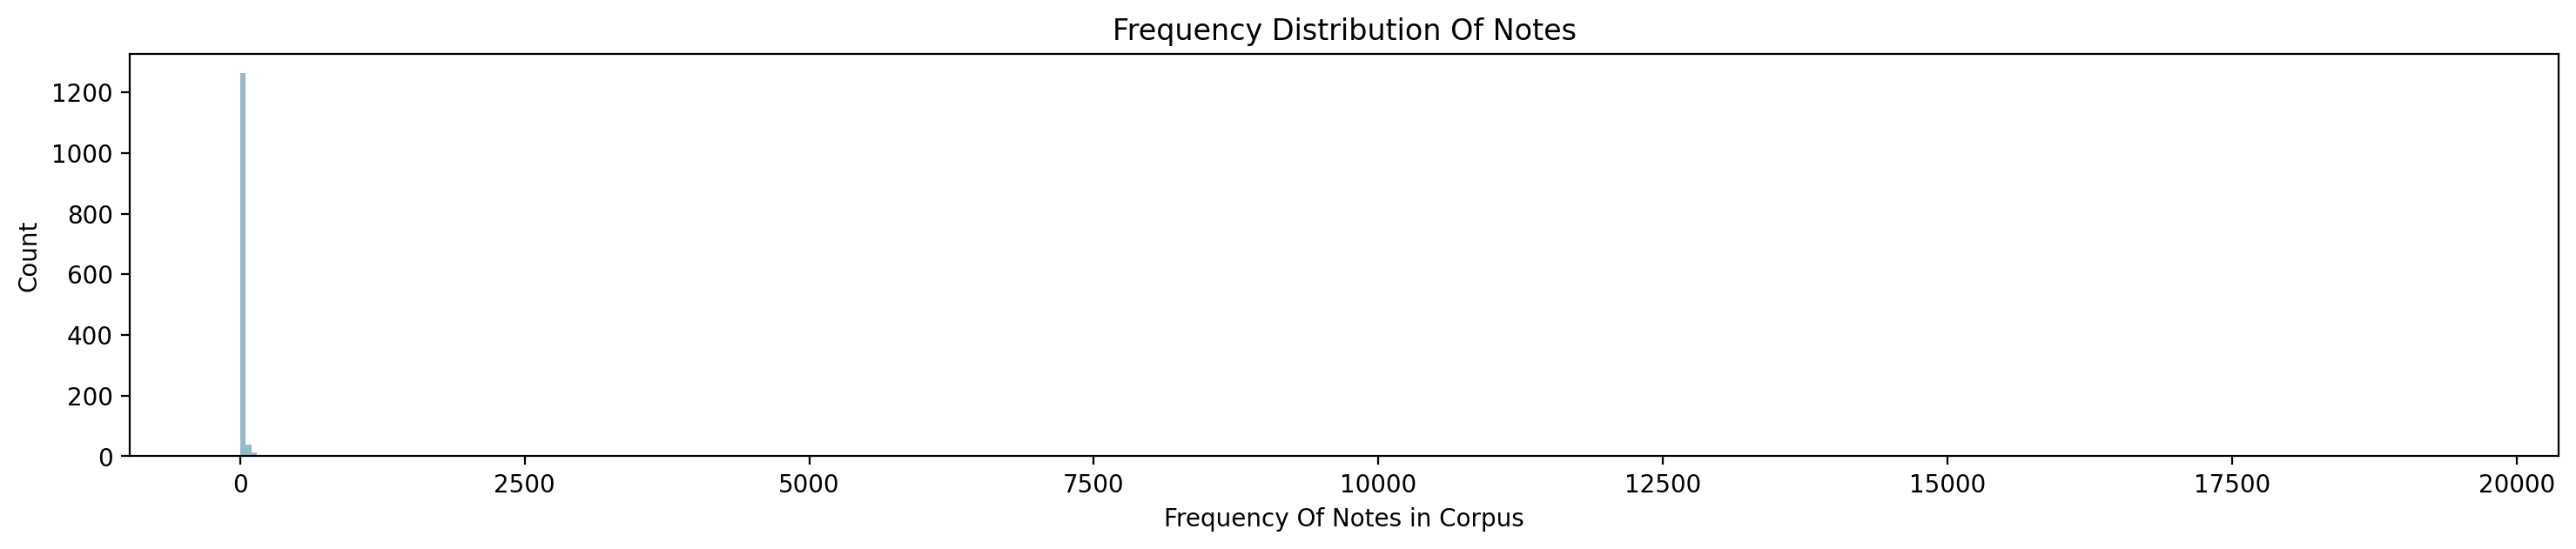

--- Durations ---
Total unique durations: 37
Average recurrence: 2031.70
Most frequent durations appeared: 40977 times
Least frequent durations appeared: 1 time


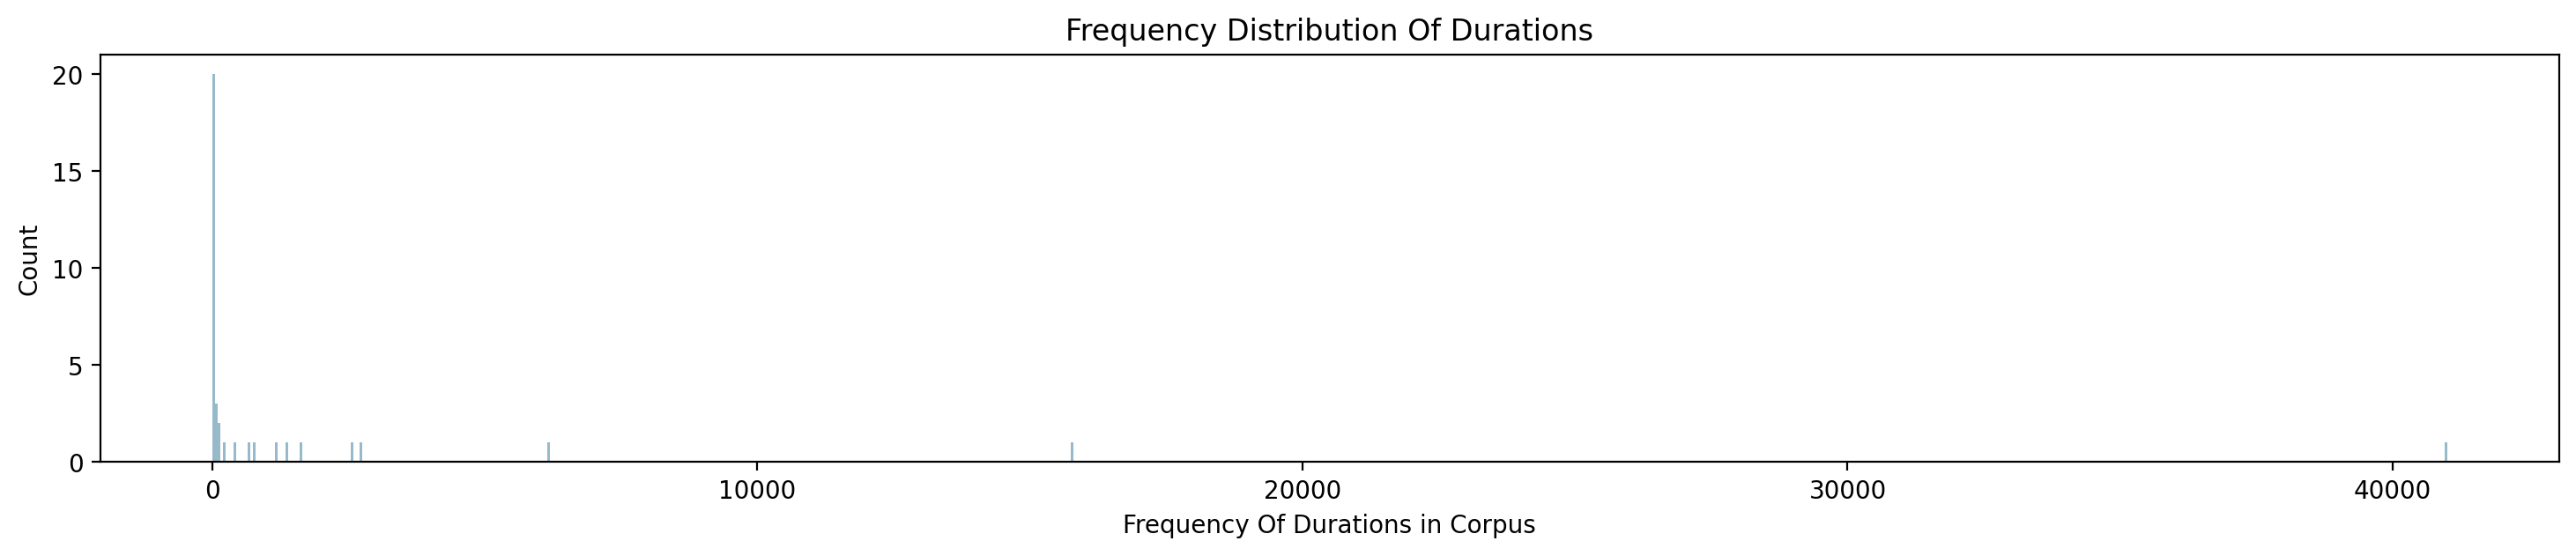

--- Tempos ---
Total unique tempos: 20
Average recurrence: 3758.65
Most frequent tempos appeared: 8571 times
Least frequent tempos appeared: 1058 time


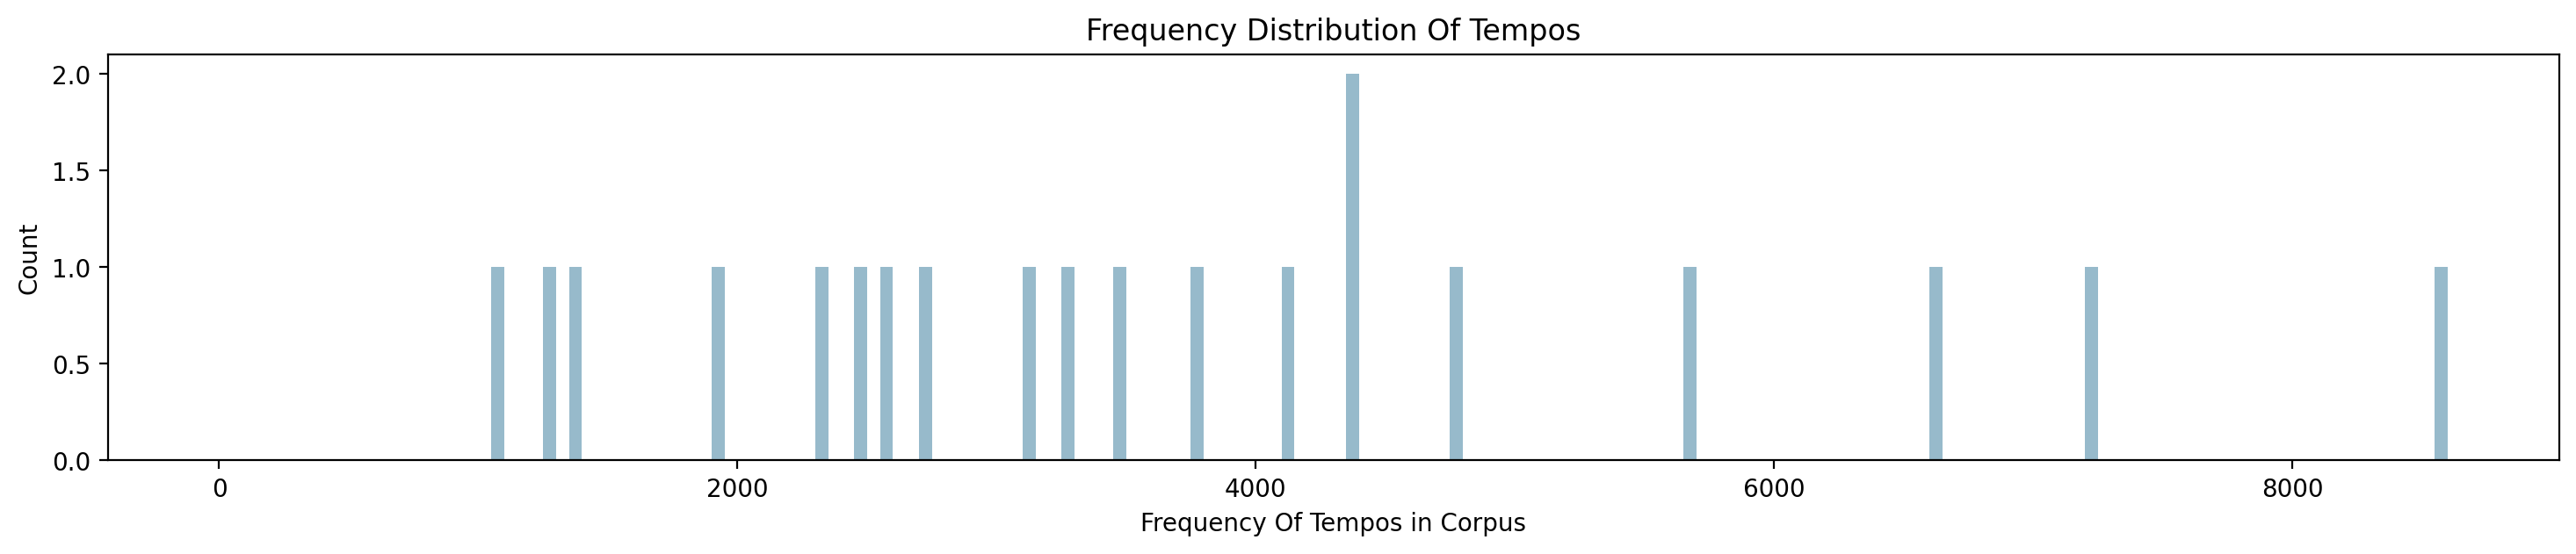

In [40]:
# Analyze frequencies for notes, durations, and tempos
notes_counter = Counter(all_notes)
durations_counter = Counter(all_durations)
tempos_counter = Counter(all_tempos)

# Helper function to calculate average recurrence
def calculate_average(lst):
    return sum(lst) / len(lst)

# Extracting keys and values for each counter
def analyze_counter(counter, label):
    items = list(counter.keys())
    recurrence = list(counter.values())
    print(f"--- {label} ---")
    print(f"Total unique {label.lower()}: {len(counter)}")
    print(f"Average recurrence: {calculate_average(recurrence):.2f}")
    print(f"Most frequent {label.lower()} appeared: {max(recurrence)} times")
    print(f"Least frequent {label.lower()} appeared: {min(recurrence)} time")
    
    # Plotting the distribution
    plt.figure(figsize=(18, 3))
    bins = np.arange(0, max(recurrence) + 50, 50) 
    plt.hist(recurrence, bins=bins, color="#97BACB")
    plt.title(f"Frequency Distribution Of {label.title()}")
    plt.xlabel(f"Frequency Of {label.title()} in Corpus")
    plt.ylabel("Count")
    plt.show()

# Analyze and plot for each feature
analyze_counter(notes_counter, "Notes")
analyze_counter(durations_counter, "Durations")
analyze_counter(tempos_counter, "Tempos")

# Data Cleaning and Feature Engineering

In [41]:
# Define thresholds
note_threshold = 150

# Filter notes, durations, and tempos
filtered_notes = {note for note, count in notes_counter.items() if count >= note_threshold}

# Filter the sequences
filtered_all_notes = [note for note in all_notes if note in filtered_notes]

In [42]:
print(len(filtered_all_notes))

63510


In [44]:
sequence_length = 64

In [48]:
def prepare_sequences(notes, durations, tempos, sequence_length):
    """
    Prepare input and output sequences for model training.

    Args:
        notes (list): List of notes extracted from MIDI files.
        durations (list): List of durations corresponding to the notes.
        tempos (list): List of tempos corresponding to the notes.
        sequence_length (int): Length of input sequences.

    Returns:
        tuple: Normalized input sequences (numpy array) and one-hot encoded output sequences (numpy array).
    """
    # Create mappings to convert data to integers
    note_to_int = {note: idx for idx, note in enumerate(sorted(set(notes)))}
    duration_to_int = {duration: idx for idx, duration in enumerate(sorted(set(durations)))}
    tempo_to_int = {tempo: idx for idx, tempo in enumerate(sorted(set(tempos)))}

    input_sequences = []
    output_sequences = []

    # Create sequences for input and corresponding output
    for i in range(len(notes) - sequence_length):
        sequence_in = [
            [
                note_to_int[notes[i + j]],
                duration_to_int[durations[i + j]],
                tempo_to_int[tempos[i + j]]
            ]
            for j in range(sequence_length)
        ]
        sequence_out = note_to_int[notes[i + sequence_length]]  # Predict the next note
        input_sequences.append(sequence_in)
        output_sequences.append(sequence_out)

    # Convert to numpy arrays
    input_sequences = np.array(input_sequences)
    output_sequences = np.array(output_sequences)

    # Normalize input features (note, duration, tempo) to range [0, 1]
    input_sequences = input_sequences / np.max(input_sequences)

    # One-hot encode the output
    output_sequences = to_categorical(output_sequences, num_classes=len(note_to_int))

    return input_sequences, output_sequences

In [49]:
# Prepare sequences with filtered data
input_sequences, output_sequences = prepare_sequences(
    filtered_all_notes, all_durations, all_tempos, sequence_length
)

# Print updated sequence shapes
print("Filtered Input shape:", input_sequences.shape)
print("Filtered Output shape:", output_sequences.shape)

Filtered Input shape: (63446, 64, 3)
Filtered Output shape: (63446, 42)


# Model Exploration

In [56]:
# Model parameters
input_shape = (sequence_length, input_sequences.shape[2])
num_classes = output_sequences.shape[1]

# Build the model
model = Sequential([
    LSTM(256, input_shape=input_shape, return_sequences=True),
    Dropout(0.4),
    LSTM(128),
    #Dropout(0.4),
    #Dense(256, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adamax(learning_rate=0.01))

# Display the model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 64, 256)        │       266,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 42)             │         5,418 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 468,778 (1.79 MB)

 Trainable params: 468,778 (1.79 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Training parameters
batch_size = 512
epochs = 10

# Train the model
history = model.fit(
    input_sequences,
    output_sequences,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 87s 844ms/step - loss: 3.1852 - val_loss: 3.1960
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - loss: 3.0016 - val_loss: 3.1702
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - loss: 2.9610 - val_loss: 3.1639
Epoch 4/10
 25/100 ━━━━━━━━━━━━━━━━━━━━ 1:06 884ms/step - loss: 2.9632

KeyboardInterrupt: 

In [ ]:
val_loss, val_accuracy = model.evaluate(input_sequences, output_sequences, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

In [ ]:
def generate_music(model, seed_sequence, note_to_int, int_to_note, sequence_length, num_generate=100):
    generated_notes = []
    sequence = seed_sequence.copy()

    for _ in range(num_generate):
        # Reshape input sequence for prediction
        input_seq = np.reshape(sequence, (1, sequence_length, len(sequence[0])))

        # Predict next note
        predicted_probs = model.predict(input_seq, verbose=0)
        predicted_index = np.argmax(predicted_probs)

        # Convert back to note
        predicted_note = int_to_note[predicted_index]
        generated_notes.append(predicted_note)

        # Update the sequence
        sequence = sequence[1:] + [[predicted_note]]

    return generated_notes

In [ ]:
# Example: Generate music from a random seed
seed_idx = random.randint(0, len(input_sequences) - 1)
seed_sequence = input_sequences[seed_idx]
int_to_note = {idx: note for note, idx in note_to_int.items()}

generated_notes = generate_music(model, seed_sequence, note_to_int, int_to_note, sequence_length)
print("Generated Notes:", generated_notes)

In [ ]:
output_dir = 'Generated'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
melody.write('midi', os.path.join(output_dir, 'Generated_Melody2.mid'))

'Generated\\Generated_Melody1.mid'

In [ ]:
IPython.display.Audio("Generated\Generated_Melody1.mp3")

# Fine-tuning of models